# MSc in Data Analytics
# Sentiment Analysis Assignment

Assessment Task
Students are advised to review and adhere to the submission requirements documented after the assessment task.  
In this continuous assessment, You are required to identify and carry out an analysis of a large dataset gleaned from the twitter API. Instructions for accessing the data can be found here  
https://datascienceparichay.com/article/get-data-from-twitter-api-in-python-step-by-step-guide/  
https://www.toptal.com/apache/apache-spark-streaming-twitter  
OR You may use the data held here:  
https://archive.org/details/twitterstream?sort=-publicdate  
You must collect at least 1 year's tweets on a topic, this data should be stored as requested below, and you are then required to analyse any change sentiment that occurs over the time period that you have selected.  
Following your analysis, you are then required to make a time series forecast of the sentiment at 1 week, 1 month and 3 months going forward. This forecast must be displayed as a dynamic dashboard.   

### Assignment
Topic: vaccine

this notebook will read the dataset containing only the tweeets related to vaccine.  
The dataset represent tweets from June 2020 until May 2021. **The dataset was downloaded from the link https://archive.org/details/twitterstream?sort=-publicdate**  


## Import filtered tweets into MongoDB and EDA step 1

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col
import pyspark.sql.functions as F

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

import json, os

In [3]:
# Read the directory with the tweets filtered by topic
dataset_path = r'/home/hduser/dataset/twitter/topic'

In [4]:
# Create the Spark Context

spark = SparkSession \
    .builder \
    .appName("sba22243-sentiment") \
    .config("spark.sql.debug.maxToStringFields", 100) \
    .config("spark.mongodb.input.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config("spark.mongodb.output.uri", "mongodb://192.168.0.107/sba22243.vaccine") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.2') \
    .getOrCreate()
sqlContext = spark._wrapped

### Import filtered tweets from filesystem into MongoDB

In [5]:
# Read all files using Spark
dataframe = sqlContext.read.json('file://' + dataset_path + '/vaccine-*.json')

In [6]:
dataframe.show(20)

+--------------------+---------+--------------------+-------------+
|          created_at|retweeted|                text| timestamp_ms|
+--------------------+---------+--------------------+-------------+
|Thu Mar 18 16:30:...|    false|WASHINGTON (@AP) ...|1616085014664|
|Thu Mar 18 16:30:...|    false|You say this vacc...|1616085017658|
|Thu Mar 18 16:30:...|    false|@FauciFan I’ll ta...|1616085032660|
|Thu Mar 18 16:21:...|    false|That EU COVID-19 ...|1616084470665|
|Thu Mar 18 16:21:...|    false|@MissCB26 @shungs...|1616084471660|
|Thu Mar 18 16:21:...|    false|🚨People from 20 ...|1616084485662|
|Thu Mar 18 16:21:...|    false|Napoleon was cont...|1616084490657|
|Thu Mar 18 16:21:...|    false|Coronavirus live:...|1616084511663|
|Thu Mar 18 16:02:...|    false|@cnni Until Bill ...|1616083333666|
|Thu Mar 18 16:02:...|    false|Johnson Johnson v...|1616083338658|
|Thu Mar 18 16:02:...|    false|Italy opens mansl...|1616083352659|
|Thu Mar 18 16:02:...|    false|It is no coincide

In [7]:
dataframe.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)



In [8]:
dataframe.describe().show()

+-------+--------------------+--------------------+--------------------+
|summary|          created_at|                text|        timestamp_ms|
+-------+--------------------+--------------------+--------------------+
|  count|              242125|              242125|              242125|
|   mean|                null|                null|1.610587907342281...|
| stddev|                null|                null|  7.24723910703953E9|
|    min|Fri Apr 02 00:02:...|! India starts te...|       1590995006659|
|    max|Wed Sep 30 23:59:...|🩺💉Covid-19: Wil...|       1622527004664|
+-------+--------------------+--------------------+--------------------+



In [9]:
# filter out retweets
# check if retweet == True
tmp = dataframe.filter(dataframe.retweeted == True)
tmp.show()

+----------+---------+----+------------+
|created_at|retweeted|text|timestamp_ms|
+----------+---------+----+------------+
+----------+---------+----+------------+



In [10]:
# Sort ascending
dataframe = dataframe.orderBy("timestamp_ms")

In [11]:
# Remove tweets that begin with "RT " as they are retweets as well
dataframe = dataframe.filter(~dataframe.text.startswith('RT '))

In [12]:
dataframe.count()

194127

In [13]:
# Remove web address from the tweets
dataframe = dataframe.withColumn("text", F.regexp_replace("text", "https?://\\\\S+", ""))

In [14]:
# Remove the emoji and not ASCII characters from the text
dataframe = dataframe.withColumn("text", F.regexp_replace("text", "[^\\x00-\\x7F]+", ""))

In [15]:
dataframe.show(20)

+--------------------+---------+--------------------+-------------+
|          created_at|retweeted|                text| timestamp_ms|
+--------------------+---------+--------------------+-------------+
|Mon Jun 01 07:03:...|    false|@MikeSwadling @Ja...|1590995006659|
|Mon Jun 01 07:42:...|    false|Oxford Biomedica ...|1590997328663|
|Mon Jun 01 07:58:...|    false|The race for a va...|1590998284666|
|Mon Jun 01 08:16:...|    false|@kaajalActress Is...|1590999372665|
|Mon Jun 01 08:40:...|    false|@BorisJohnson The...|1591000848665|
|Mon Jun 01 08:45:...|    false|@xandvt Unfortuna...|1591001151663|
|Mon Jun 01 08:49:...|    false|Doesnt this also ...|1591001383662|
|Mon Jun 01 09:55:...|    false|@WhiteHouse @POTU...|1591005305662|
|Mon Jun 01 09:59:...|    false|#CoronaIsNotAJoke...|1591005559660|
|Mon Jun 01 10:04:...|    false|@drmansoor140 Yes...|1591005888663|
|Mon Jun 01 10:17:...|    false|she's ANTI-VACCIN...|1591006634661|
|Mon Jun 01 10:20:...|    false|How? Why? Is the

In [16]:
# Remove the retweeted column
dataframe = dataframe.drop("retweeted")

In [17]:
dataframe.show(5)

+--------------------+--------------------+-------------+
|          created_at|                text| timestamp_ms|
+--------------------+--------------------+-------------+
|Mon Jun 01 07:03:...|@MikeSwadling @Ja...|1590995006659|
|Mon Jun 01 07:42:...|Oxford Biomedica ...|1590997328663|
|Mon Jun 01 07:58:...|The race for a va...|1590998284666|
|Mon Jun 01 08:16:...|@kaajalActress Is...|1590999372665|
|Mon Jun 01 08:40:...|@BorisJohnson The...|1591000848665|
+--------------------+--------------------+-------------+
only showing top 5 rows



In [18]:
# extract the day, the month and the year from the timestamp

dataframe = dataframe.withColumn("unix_timestamp", F.to_timestamp(F.col("timestamp_ms")/1000))
dataframe = dataframe.withColumn("day", F.date_format(F.col("unix_timestamp"), "d"))
dataframe = dataframe.withColumn("month", F.date_format(F.col("unix_timestamp"), "M"))
dataframe = dataframe.withColumn("year", F.date_format(F.col("unix_timestamp"), "y"))
dataframe = dataframe.withColumn("full_date", F.date_format(F.col("unix_timestamp"), "yyyy-MM-dd"))
dataframe = dataframe.drop("unix_timestamp")

In [19]:
dataframe.show()

+--------------------+--------------------+-------------+---+-----+----+----------+
|          created_at|                text| timestamp_ms|day|month|year| full_date|
+--------------------+--------------------+-------------+---+-----+----+----------+
|Mon Jun 01 07:03:...|@MikeSwadling @Ja...|1590995006659|  1|    6|2020|2020-06-01|
|Mon Jun 01 07:42:...|Oxford Biomedica ...|1590997328663|  1|    6|2020|2020-06-01|
|Mon Jun 01 07:58:...|The race for a va...|1590998284666|  1|    6|2020|2020-06-01|
|Mon Jun 01 08:16:...|@kaajalActress Is...|1590999372665|  1|    6|2020|2020-06-01|
|Mon Jun 01 08:40:...|@BorisJohnson The...|1591000848665|  1|    6|2020|2020-06-01|
|Mon Jun 01 08:45:...|@xandvt Unfortuna...|1591001151663|  1|    6|2020|2020-06-01|
|Mon Jun 01 08:49:...|Doesnt this also ...|1591001383662|  1|    6|2020|2020-06-01|
|Mon Jun 01 09:55:...|@WhiteHouse @POTU...|1591005305662|  1|    6|2020|2020-06-01|
|Mon Jun 01 09:59:...|#CoronaIsNotAJoke...|1591005559660|  1|    6|2020|2020

In [20]:
dataframe.describe().show()

+-------+--------------------+--------------------+--------------------+------------------+------------------+------------------+----------+
|summary|          created_at|                text|        timestamp_ms|               day|             month|              year| full_date|
+-------+--------------------+--------------------+--------------------+------------------+------------------+------------------+----------+
|  count|              194127|              194127|              194127|            194127|            194127|            194127|    194127|
|   mean|                null|                null|1.610492008004498...|14.865593142633431|  6.64315628428812|2020.5257383053363|      null|
| stddev|                null|                null| 8.071449773431386E9| 9.093458618552686|3.7720981514155443|0.4993383863162408|      null|
|    min|Fri Apr 02 00:02:...|

 Russia present...|       1590995006659|                 1|                 1|              2020|2020-06-01|
|    max|Wed 

In [21]:
# count how manny tweets per day are in the dataset
dataset = dataframe.groupBy("full_date").count().toPandas()

In [22]:
dataset = dataset.sort_values("full_date")

In [23]:
dataset.head()

,full_date,count
81,2020-06-01,73
251,2020-06-02,104
201,2020-06-03,39
260,2020-06-04,131
250,2020-06-05,160


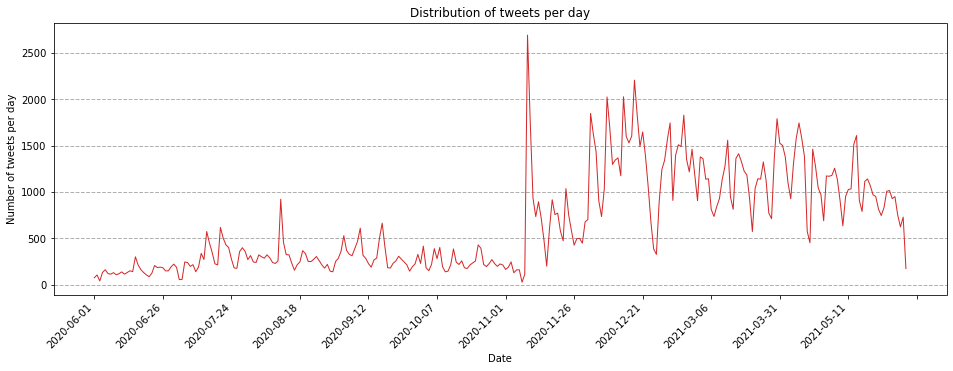

In [24]:
# plot the tweet distribution

plt.figure(figsize=(16,5))
locator = MaxNLocator(nbins=14)
plt.plot(dataset['full_date'], dataset['count'], color='tab:red', linewidth = '1')
plt.gca().set(title="Distribution of tweets per day", xlabel="Date", ylabel="Number of tweets per day")
plt.gca().xaxis.set_major_locator(locator)
plt.grid(axis = 'y', linestyle = '--', linewidth = 1)
plt.xticks(rotation=45, ha="right")
plt.show()

In [25]:
# Save dataset into MongoDB
dataframe.write.format("com.mongodb.spark.sql.DefaultSource").mode("append").option("spark.mongodb.output.uri","mongodb://192.168.0.107/sba22243.vaccine").save()

In [27]:
# Save the dataframe to a csv file for future uses
dataframe.coalesce(1).write.csv('file:///home/hduser/dataset/twitter/final/twitter-vaccine-final.csv', header=True)